 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#New-York-City-Taxi-Trip-Duration" data-toc-modified-id="New-York-City-Taxi-Trip-Duration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>New York City Taxi Trip Duration</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Credit-to:" data-toc-modified-id="Credit-to:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Credit to:</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Check-trip_duration" data-toc-modified-id="Check-trip_duration-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Check trip_duration</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Combine-train-data-and-eval-data" data-toc-modified-id="Combine-train-data-and-eval-data-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Combine train data and eval data</a></span></li></ul></li></ul></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Pre-process-data" data-toc-modified-id="Pre-process-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pre-process data</a></span><ul class="toc-item"><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Check-NaN-columns" data-toc-modified-id="Check-NaN-columns-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Check NaN columns</a></span></li></ul><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Transform-object-data" data-toc-modified-id="Transform-object-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Transform object data</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Convert-datetime-string-to-object" data-toc-modified-id="Convert-datetime-string-to-object-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Convert datetime string to object</a></span></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#store_and_fwd_flag" data-toc-modified-id="store_and_fwd_flag-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>store_and_fwd_flag</a></span></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Drop-unused-cols" data-toc-modified-id="Drop-unused-cols-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Drop unused cols</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Feature-scaling-(not-use)" data-toc-modified-id="Feature-scaling-(not-use)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Feature scaling (not use)</a></span></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Feature-engineering" data-toc-modified-id="Feature-engineering-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Feature engineering</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Distance-between-pickup-and-dropoff" data-toc-modified-id="Distance-between-pickup-and-dropoff-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Distance between pickup and dropoff</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Clearning-data" data-toc-modified-id="Clearning-data-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Clearning data</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Split-train_set-and-eval_set" data-toc-modified-id="Split-train_set-and-eval_set-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Split train_set and eval_set</a></span></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Trip-duration-outliner" data-toc-modified-id="Trip-duration-outliner-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Trip duration outliner</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Search-for-outliner" data-toc-modified-id="Search-for-outliner-3.4.2.1"><span class="toc-item-num">3.4.2.1&nbsp;&nbsp;</span>Search for outliner</a></span></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Drop-trip-duration-outliner" data-toc-modified-id="Drop-trip-duration-outliner-3.4.2.2"><span class="toc-item-num">3.4.2.2&nbsp;&nbsp;</span>Drop trip-duration outliner</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Trip-duration-distribution" data-toc-modified-id="Trip-duration-distribution-3.4.3"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>Trip duration distribution</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Feature-correlation" data-toc-modified-id="Feature-correlation-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Feature correlation</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Train-model" data-toc-modified-id="Train-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train model</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Model-definition" data-toc-modified-id="Model-definition-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Model definition</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Find-the-best-hyperparam-for-model-using-GridSearchCV-(not-use)" data-toc-modified-id="Find-the-best-hyperparam-for-model-using-GridSearchCV-(not-use)-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Find the best hyperparam for model using GridSearchCV (not use)</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Tuning-param-after-GridSearchCV-(not-use)" data-toc-modified-id="Tuning-param-after-GridSearchCV-(not-use)-4.1.1.1"><span class="toc-item-num">4.1.1.1&nbsp;&nbsp;</span>Tuning param after GridSearchCV (not use)</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Cross-validate--(not-use)" data-toc-modified-id="Cross-validate--(not-use)-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Cross validate  (not use)</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Tuning-param-after-CV--(not-use)" data-toc-modified-id="Tuning-param-after-CV--(not-use)-4.1.2.1"><span class="toc-item-num">4.1.2.1&nbsp;&nbsp;</span>Tuning param after CV  (not use)</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Plot-learning-curve-to-determine-best-train/test-split--(not-use)" data-toc-modified-id="Plot-learning-curve-to-determine-best-train/test-split--(not-use)-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Plot learning curve to determine best train/test split  (not use)</a></span></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Split-train/test-set" data-toc-modified-id="Split-train/test-set-4.1.4"><span class="toc-item-num">4.1.4&nbsp;&nbsp;</span>Split train/test set</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Train-data" data-toc-modified-id="Train-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Train data</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Predict-for-test-data" data-toc-modified-id="Predict-for-test-data-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Predict for test data</a></span></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Feature-importances" data-toc-modified-id="Feature-importances-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Feature importances</a></span></li></ul></li></ul></li><li><span><a href="http://localhost:8888/notebooks/New%20York%20City%20Taxi%20Trip%20Duration/nb-taxi-trip-duration-v1.ipynb#Predict-and-save-submission" data-toc-modified-id="Predict-and-save-submission-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Predict and save submission</a></span></li></ul></div>

# New York City Taxi Trip Duration
- Share code and data to improve ride time predictions
- https://www.kaggle.com/c/nyc-taxi-trip-duration/data
- install: http://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html
- install: https://github.com/Jupyter-contrib/jupyter_nbextensions_configurator
- install GDAL: https://sandbox.idre.ucla.edu/sandbox/tutorials/installing-gdal-for-windows
- install osmnx: http://geoffboeing.com/2014/09/using-geopandas-windows/


## Credit to:
- https://www.kaggle.com/ankasor/driving-distance-using-open-street-maps-data/notebook

In [1]:
# data processing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt
from scipy import stats
from scipy.stats import norm
import math
from numpy import sort

# ML
# # Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
# # XGB
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance
# # CatBoost
#from catboost import Pool, CatBoostRegressor, cv, CatboostIpythonWidget
# System
import datetime as dtime
from datetime import datetime
import sys
from inspect import getsourcefile
import os.path
import re
import time

# Other
from geographiclib.geodesic import Geodesic
import osmnx as ox
import networkx as nx

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

c:\users\le anh tuan\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\le anh tuan\appdata\local\programs\python\python35\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
c:\users\le anh tuan\appdata\local\programs\python\python35\lib\site-packages\geopandas\__init__.py:1: DeprecationWarning: pandas.util.decorators is deprecated and will be removed in a future version, imp

# Load data

In [2]:
# Input data files are available in the DATA_DIR directory.
DATA_DIR = "data-temp"
# Load data. Download from:https://www.kaggle.com/c/nyc-taxi-trip-duration/data
train_data = pd.read_csv(DATA_DIR + "/train.csv")
eval_data =  pd.read_csv(DATA_DIR + "/test.csv")

In [3]:
print("train size:", train_data.shape, " test size:", eval_data.shape)

train size: (1458644, 11)  test size: (625134, 9)


In [4]:
train_data.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
eval_data.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [6]:
diff_cols = np.setdiff1d(train_data.columns.values, eval_data.columns.values)
diff_cols

array(['dropoff_datetime', 'trip_duration'], dtype=object)

## Check trip_duration

In [7]:
data = train_data

In [39]:
label='trip_duration'
# data1 = data[(data[label] < 1000000) & (data[label] > 86000) ]
#data1 = data[(data[label] < 1000000) & (data[label] > 22 * 3600) ]
#data1 = data[(data[label] > 1000000) ]
# data1 = data[(data[label] <= 86000) ]
data1 = data[(data[label] <22 * 3600) ]
data1['datetime_obj'] = pd.to_datetime(data1['pickup_datetime'])

data1[label].describe()

count    1.456738e+06
mean     8.424561e+02
std      8.535369e+02
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.073000e+03
max      7.915000e+04
Name: trip_duration, dtype: float64

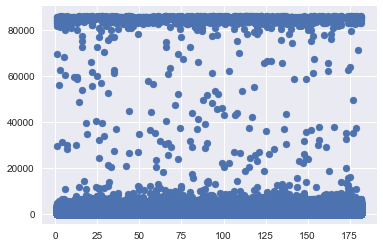

In [19]:
plt.scatter(data1['datetime_obj'].dt.dayofyear, data1[label])

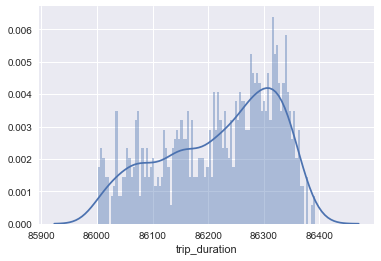

In [32]:
sns.distplot(data1[label], bins=100)

In [40]:
data2 = np.sqrt(data1[label])

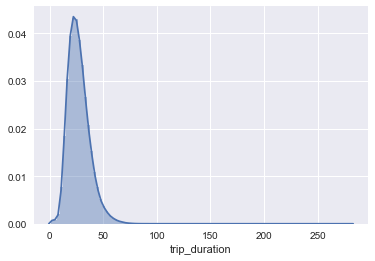

In [41]:
sns.distplot(data2, bins=100)

### Combine train data and eval data

In [3]:
label = 'trip_duration'
features = eval_data.columns.values
target = train_data[label].values
combine_data = pd.concat([train_data[features], eval_data], keys=['train','eval'])
combine_data.head(5)

id  vendor_id      pickup_datetime  passenger_count  \
train 0  id2875421          2  2016-03-14 17:24:55                1   
      1  id2377394          1  2016-06-12 00:43:35                1   
      2  id3858529          2  2016-01-19 11:35:24                1   
      3  id3504673          2  2016-04-06 19:32:31                1   
      4  id2181028          2  2016-03-26 13:30:55                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
train 0        -73.982155        40.767937         -73.964630   
      1        -73.980415        40.738564         -73.999481   
      2        -73.979027        40.763939         -74.005333   
      3        -74.010040        40.719971         -74.012268   
      4        -73.973053        40.793209         -73.972923   

         dropoff_latitude store_and_fwd_flag  
train 0         40.765602                  N  
      1         40.731152                  N  
      2         40.710087                  N  
      3         40.706718                  N  
      4         40.782520                  N

# Pre-process data

### Check NaN columns

In [4]:
def check_null_data(data):
    #Get high percent of NaN data
    null_data = combine_data.isnull()
    total = null_data.sum().sort_values(ascending=False)
    percent = (null_data.sum()/null_data.count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    high_percent_miss_data = missing_data[missing_data['Percent']>0]
    #print(missing_data)
    print(high_percent_miss_data)
    miss_data_cols = high_percent_miss_data.index.values
    return miss_data_cols

In [9]:
# Check target for null
check_null_data(target)

Empty DataFrame
Columns: [Total, Percent]
Index: []


array([], dtype=object)

In [10]:
# combine data for null
check_null_data(combine_data)

Empty DataFrame
Columns: [Total, Percent]
Index: []


array([], dtype=object)

In [11]:
combine_data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object

## Transform object data

In [5]:
data = combine_data

### Convert datetime string to object

In [6]:
def pd_datetime(data):
    date_format = "%Y-%m-%d %H:%M:%S"
    datetime_obj = data['pickup_datetime'].apply(lambda x: datetime.strptime(x, date_format))
    return datetime_obj 

In [7]:
#data['datetime_obj'] = pd_datetime(data)
data['datetime_obj'] = pd.to_datetime(data['pickup_datetime'])
data['datetime_obj'][:5]

train  0   2016-03-14 17:24:55
       1   2016-06-12 00:43:35
       2   2016-01-19 11:35:24
       3   2016-04-06 19:32:31
       4   2016-03-26 13:30:55
Name: datetime_obj, dtype: datetime64[ns]

In [8]:
data['pickup_year'] = data['datetime_obj'].dt.year
data['pickup_month'] = data['datetime_obj'].dt.month
data['pickup_weekday'] = data['datetime_obj'].dt.weekday
data['pickup_day'] = data['datetime_obj'].dt.day
data['pickup_hour'] = data['datetime_obj'].dt.hour
data['pickup_minute'] = data['datetime_obj'].dt.minute

In [10]:
data[:5]

id  vendor_id      pickup_datetime  passenger_count  \
train 0  id2875421          2  2016-03-14 17:24:55                1   
      1  id2377394          1  2016-06-12 00:43:35                1   
      2  id3858529          2  2016-01-19 11:35:24                1   
      3  id3504673          2  2016-04-06 19:32:31                1   
      4  id2181028          2  2016-03-26 13:30:55                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
train 0        -73.982155        40.767937         -73.964630   
      1        -73.980415        40.738564         -73.999481   
      2        -73.979027        40.763939         -74.005333   
      3        -74.010040        40.719971         -74.012268   
      4        -73.973053        40.793209         -73.972923   

         dropoff_latitude store_and_fwd_flag        datetime_obj  pickup_year  \
train 0         40.765602                  N 2016-03-14 17:24:55         2016   
      1         40.731152                  N 2016-06-12 00:43:35         2016   
      2         40.710087                  N 2016-01-19 11:35:24         2016   
      3         40.706718                  N 2016-04-06 19:32:31         2016   
      4         40.782520                  N 2016-03-26 13:30:55         2016   

         pickup_month  pickup_weekday  pickup_day  pickup_hour  pickup_minute  
train 0             3               0          14           17             24  
      1             6               6          12            0             43  
      2             1               1          19           11             35  
      3             4               2           6           19             32  
      4             3               5          26           13             30

### store_and_fwd_flag

In [9]:
col = 'store_and_fwd_flag'
data[col].value_counts()

N    2072303
Y      11475
Name: store_and_fwd_flag, dtype: int64

In [10]:
data_dict = {'Y':1, 'N':0}
data_tf = data[col].map(data_dict)
data[col].update(data_tf)
data[:5]

id  vendor_id      pickup_datetime  passenger_count  \
train 0  id2875421          2  2016-03-14 17:24:55                1   
      1  id2377394          1  2016-06-12 00:43:35                1   
      2  id3858529          2  2016-01-19 11:35:24                1   
      3  id3504673          2  2016-04-06 19:32:31                1   
      4  id2181028          2  2016-03-26 13:30:55                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
train 0        -73.982155        40.767937         -73.964630   
      1        -73.980415        40.738564         -73.999481   
      2        -73.979027        40.763939         -74.005333   
      3        -74.010040        40.719971         -74.012268   
      4        -73.973053        40.793209         -73.972923   

         dropoff_latitude store_and_fwd_flag        datetime_obj  pickup_year  \
train 0         40.765602                  0 2016-03-14 17:24:55         2016   
      1         40.731152                  0 2016-06-12 00:43:35         2016   
      2         40.710087                  0 2016-01-19 11:35:24         2016   
      3         40.706718                  0 2016-04-06 19:32:31         2016   
      4         40.782520                  0 2016-03-26 13:30:55         2016   

         pickup_month  pickup_weekday  pickup_day  pickup_hour  pickup_minute  
train 0             3               0          14           17             24  
      1             6               6          12            0             43  
      2             1               1          19           11             35  
      3             4               2           6           19             32  
      4             3               5          26           13             30

### Drop unused cols

In [11]:
# Drop pickup_datetime
data.drop('pickup_datetime', axis=1, inplace=True)
data.drop('datetime_obj', axis=1, inplace=True)

In [12]:
combine_data_tf = data

## Feature scaling (not use)

In [13]:
combine_data_tf['pickup_year'].value_counts()

2016    2083778
Name: pickup_year, dtype: int64

In [14]:
# Drop pickup year
combine_data_tf.drop('pickup_year', axis=1, inplace=True)

## Feature engineering

### Distance between pickup and dropoff

In [65]:
geod = Geodesic.WGS84  # define the WGS84 ellipsoid


def point_distance(startpoint, endpoint):
    distance = geod.Inverse(
        startpoint[0], startpoint[1], endpoint[0], endpoint[1])
    return distance['s12']

In [66]:
def driving_distance(area_graph, startpoint, endpoint):
    """
    Calculates the driving distance along an osmnx street network between two coordinate-points.
    The Driving distance is calculated from the closest nodes to the coordinate points.
    This can lead to problems if the coordinates fall outside the area encompassed by the network.

    Arguments:
    area_graph -- An osmnx street network
    startpoint -- The Starting point as coordinate Tuple
    endpoint -- The Ending point as coordinate Tuple
    """

    # Find nodes closest to the specified Coordinates
    node_start = ox.utils.get_nearest_node(area_graph, startpoint)
    node_stop = ox.utils.get_nearest_node(area_graph, endpoint)
    #print("node_start:", node_start, " node_stop:", node_stop)
    # Calculate the shortest network distance between the nodes via the edges
    # "length" attribute
    try:
        distance = nx.shortest_path_length(
            area_graph, node_start, node_stop, weight="length")
    except:
        print("Can not calculate path from ", startpoint,
              " to ", endpoint, ". Using backup function")
        distance = point_distance(startpoint, endpoint)

    return distance

In [1]:
# credit to: https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [ ]:
data = combine_data_tf
data['distance'] = combine_data_tf.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
combine_data_tf[:5]

## Clearning data

### Split train_set and eval_set

In [197]:
data = combine_data_tf
train_set = data.loc['train']
eval_set = data.loc['eval']
data = train_set
data[label] = target
target_log = np.log(target)
data[:5]

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_weekday,pickup_day,pickup_hour,pickup_minute,distance,trip_duration
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,0,3,0,14,17,24,1502.171837,455
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,0,6,6,12,0,43,1808.659969,663
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,0,1,1,19,11,35,6379.687175,2124
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,0,4,2,6,19,32,1483.632481,429
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,0,3,5,26,13,30,1187.037659,435


### Trip duration outliner

####  Search for outliner

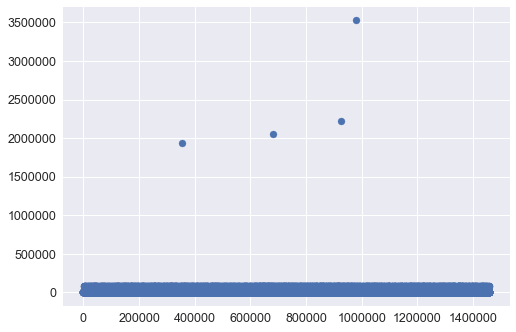

In [138]:
plt.scatter(data.index, data[label])

 - Note: Outliners are trip_duration> 1800000

In [139]:
data = train_set
data_ol = data[data[label] > 1800000]
data_ol[-5:]

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday,trip_duration
355003,id1864733,1,1,-73.789650,40.643559,-73.956810,40.773087,0,2016,1,5,0,1,1939736
680594,id0369307,1,2,-73.921677,40.735252,-73.984749,40.759979,0,2016,2,13,22,5,2049578
924150,id1325766,1,1,-73.983788,40.742325,-73.985489,40.727676,0,2016,1,5,6,1,2227612
978383,id0053347,1,1,-73.783905,40.648632,-73.978271,40.750202,0,2016,2,13,22,5,3526282


#### Drop trip-duration outliner

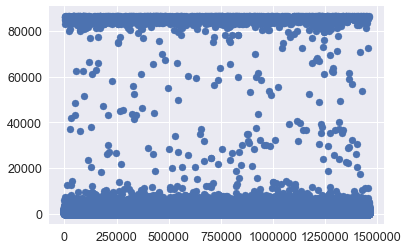

In [198]:
data_ol = data[data[label] < 1800000]
plt.scatter(data_ol.index, data_ol[label])

In [199]:
train_set = data_ol
data = train_set
# use np.log to balance distribution
target_log = np.log(train_set[label].values)

In [185]:
train_set[label].describe()

count    1.458640e+06
mean     9.528153e+02
std      3.171322e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      8.639200e+04
Name: trip_duration, dtype: float64

### Trip duration distribution

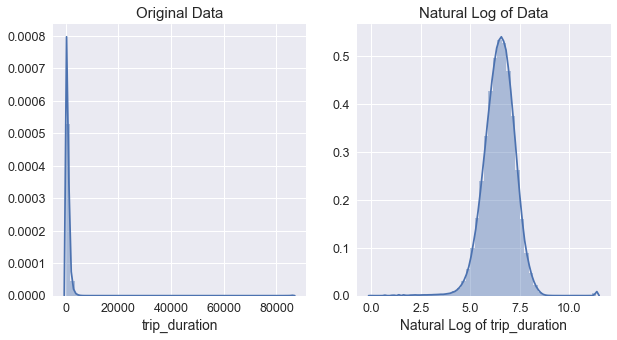

In [149]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(data[label], bins=50)
plt.title('Original Data')
plt.xlabel(label)
plt.subplot(1,2,2)
sns.distplot(target_log, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of ' + label)


## Feature correlation

In [81]:
correlation = data.corr()[label].sort_values()[-20:]
correlation

pickup_latitude     -0.194434
dropoff_latitude    -0.160230
pickup_weekday      -0.033654
vendor_id            0.008366
pickup_day           0.011006
passenger_count      0.015356
pickup_hour          0.031282
pickup_month         0.057805
dropoff_longitude    0.111933
pickup_longitude     0.189226
trip_duration        1.000000
Name: trip_duration, dtype: float64

['trip_duration' 'distance' 'pickup_longitude' 'vendor_id'
 'dropoff_longitude' 'passenger_count' 'pickup_month' 'pickup_hour'
 'pickup_day' 'pickup_weekday' 'pickup_minute' 'dropoff_latitude'
 'pickup_latitude']


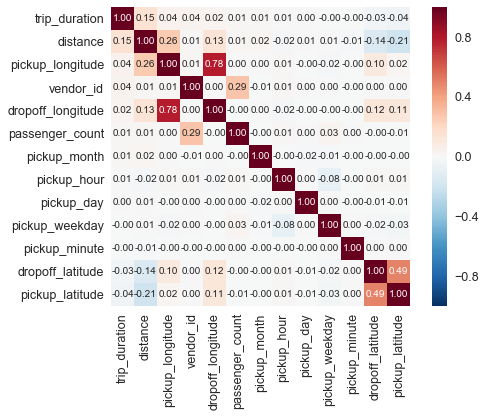

In [200]:
#correlation matrix
corrmat = data.corr()
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, label)[label].index
print(cols.values)
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

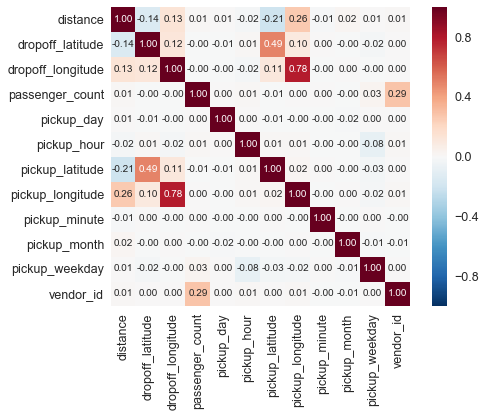

In [201]:
# Correlation matrix of cols except label
other_cols = np.setdiff1d(cols.values, label)
cm = np.corrcoef(data[other_cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=other_cols, xticklabels=other_cols)
plt.show()

# Train model

In [202]:
data = train_set.drop(['id', label], axis=1).astype(float)
print(data.shape)
data[:5]

(1458640, 13)


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_weekday,pickup_day,pickup_hour,pickup_minute,distance
0,2.0,1.0,-73.982155,40.767937,-73.964630,40.765602,0.0,3.0,0.0,14.0,17.0,24.0,1502.171837
1,1.0,1.0,-73.980415,40.738564,-73.999481,40.731152,0.0,6.0,6.0,12.0,0.0,43.0,1808.659969
2,2.0,1.0,-73.979027,40.763939,-74.005333,40.710087,0.0,1.0,1.0,19.0,11.0,35.0,6379.687175
3,2.0,1.0,-74.010040,40.719971,-74.012268,40.706718,0.0,4.0,2.0,6.0,19.0,32.0,1483.632481
4,2.0,1.0,-73.973053,40.793209,-73.972923,40.782520,0.0,3.0,5.0,26.0,13.0,30.0,1187.037659


## Model definition

In [27]:
# A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
# credit: https://www.kaggle.com/marknagelberg/rmsle-function


def rmsle(y, y_pred, log=True):
    assert len(y) == len(y_pred)
    terms_to_sum = 0
    if log:
        terms_to_sum = [(math.log(math.fabs(y_pred[i]) + 1) -
                         math.log(y[i] + 1)) ** 2.0 for i, pred in enumerate(y_pred)]
    else:
        terms_to_sum = [(math.fabs(y_pred[i]) - y[i]) **
                        2.0 for i, pred in enumerate(y_pred)]
    # for i, pred in enumerate(y_pred):
    #    print("i:", i, " pred:", y_pred[i])
    #    print(math.log(y_pred[i] + 1))
    #    print(math.log(y[i] + 1))
    return (sum(terms_to_sum) * (1.0 / len(y))) ** 0.5

In [203]:
#model = CatBoostRegressor(iterations=100, depth=5, thread_count=4, use_best_model=True)
model = XGBRegressor(n_estimators=10000, max_depth=5,
                     learning_rate=0.1, min_child_weight=1, n_jobs=-1)

### Find the best hyperparam for model using GridSearchCV (not use)

#### Tuning param after GridSearchCV (not use)

### Cross validate  (not use)

#### Tuning param after CV  (not use)

### Plot learning curve to determine best train/test split  (not use)

In [29]:
def plot_learning_curve(X, Y):
    plt.figure(figsize=(20,10))
    plt.title("Learing curve")
    # if ylim is not None:
    #     plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(model, X, Y)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

### Split train/test set

In [204]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data, target_log, train_size=0.85, random_state=1234)
print("X_train:", X_train.shape, " Y_train:", Y_train.shape,
      " X_test:", X_test.shape, " Y_test:", Y_test.shape)
X_train[:5]

X_train: (1239844, 13)  Y_train: (1239844,)  X_test: (218796, 13)  Y_test: (218796,)


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_weekday,pickup_day,pickup_hour,pickup_minute,distance
9624,2.0,1.0,-73.978073,40.737499,-73.986183,40.768196,0.0,6.0,0.0,20.0,19.0,59.0,3476.980808
390139,2.0,5.0,-73.994362,40.745819,-74.012383,40.716808,0.0,6.0,5.0,11.0,15.0,23.0,3563.171430
998910,1.0,1.0,-73.977974,40.773602,-73.977356,40.758083,0.0,1.0,6.0,17.0,17.0,0.0,1724.075012
911435,2.0,1.0,-73.981659,40.779060,-73.982292,40.775070,0.0,1.0,3.0,7.0,18.0,56.0,446.320052
129338,1.0,1.0,-73.977921,40.773502,-73.965164,40.755020,0.0,5.0,3.0,19.0,17.0,54.0,2317.883496


## Train data

In [206]:
start = time.time()
early_stopping_rounds = 50
model.fit(
    X_train, Y_train, eval_set = [(X_test, Y_test)],
    eval_metric="rmse", early_stopping_rounds=early_stopping_rounds,
    verbose=early_stopping_rounds
)
end = time.time() - start
print(end)

[0]	validation_0-rmse:5.41988
Will train until validation_0-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.442988
[100]	validation_0-rmse:0.428435
[150]	validation_0-rmse:0.42162
[200]	validation_0-rmse:0.417811
[250]	validation_0-rmse:0.415138
[300]	validation_0-rmse:0.413329
[350]	validation_0-rmse:0.41151
[400]	validation_0-rmse:0.410681
[450]	validation_0-rmse:0.409317
[500]	validation_0-rmse:0.407984
[550]	validation_0-rmse:0.406823
[600]	validation_0-rmse:0.405887
[650]	validation_0-rmse:0.40516
[700]	validation_0-rmse:0.404552
[750]	validation_0-rmse:0.404054
[800]	validation_0-rmse:0.403681
[850]	validation_0-rmse:0.403084
[900]	validation_0-rmse:0.40256
[950]	validation_0-rmse:0.402102
[1000]	validation_0-rmse:0.401561
[1050]	validation_0-rmse:0.401015
[1100]	validation_0-rmse:0.400523
[1150]	validation_0-rmse:0.400171
[1200]	validation_0-rmse:0.399798
[1250]	validation_0-rmse:0.399626
[1300]	validation_0-rmse:0.399439
[1350]	validation_0-rmse:0.399244
[1400]	vali

### Predict for test data

In [207]:
start = time.time()
y_pred = model.predict(X_test)
end = time.time() - start
end

10.470948696136475

In [208]:
# Evaluate score
print(y_pred[:5])
score = rmsle(Y_test, y_pred)
score1 = rmsle(Y_test, y_pred, log=False)
print("RMSLE score:", score, " RMSLE without-log:", score1)

[ 5.68732786  5.46377277  4.93266582  6.93084335  7.49049044]
RMSLE score: 0.05865621413937626  RMSLE without-log: 0.395957129069


### Feature importances

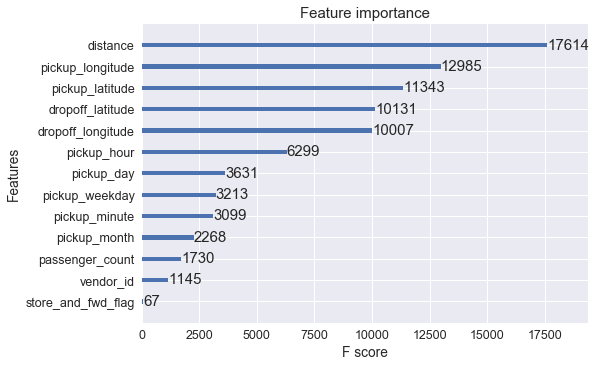

In [209]:
plot_importance(model)
plt.show()

In [ ]:
model_params = model.get_params()
model_params

In [ ]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    break
    # select features using threshold
    #print("X_train:", X_train.shape, " X_test:", X_test.shape)
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBRegressor()
    selection_model.set_params(**model_params)
    selection_model.fit(select_X_train, Y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    score = rmsle(Y_test, y_pred)
    print("Thresh=%.3f, n=%d, Score: %.2f%%" % (thresh, select_X_train.shape[1], score))

# Predict and save submission

In [210]:
start = time.time()
data = eval_set.drop('id', axis=1).astype(float)
Y_eval_log = model.predict(data)
Y_eval = np.exp(Y_eval_log.ravel())
end = time.time() - start
print(end)
print(Y_eval_log[:5])
print(Y_eval[:5])

29.91484546661377
[ 6.81487608  6.40462923  6.07336092  6.88927174  5.72299194]
[ 911.30358887  604.63757324  434.1373291   981.68621826  305.81854248]


In [211]:
eval_output = pd.DataFrame({'id': eval_data['id'], 'trip_duration': Y_eval})
print(len(eval_output))
eval_output.head()

625134


,id,trip_duration
0,id3004672,911.303589
1,id3505355,604.637573
2,id1217141,434.137329
3,id2150126,981.686218
4,id1598245,305.818542


In [214]:
start = time.time()
today = str(dtime.date.today())
print(today)
eval_output.to_csv(DATA_DIR +'/' +today+'-submission.csv',index=False)
end = time.time() - start
end

2017-07-23


2.8869168758392334